<a href="https://colab.research.google.com/github/Jibby2k1/ML4Music/blob/main/Stage_1_Filter_Investigation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### README:

First, this notebook is only possible because of UF's professor Dr. Wong - I was heavily guided by his notes and all acknowledgements go to him and his kindness. For his notes, refer to his GitHub page:
https://tanfwong.github.io/dsp_notes/ch6/firdesign.html

This is a notebook describing the few experiments and usage of python for implementing filters.

Most of the packages are built-into MATLAB, but to make this more accessible and coder friendly, we will be working with the **scipy** library in python.

In [ ]:
#from scipy import signal

For this section we need to look at filter design in the scipy.signal package. There are many approaches to filtering, let's start with analyzing FIR vs IIR filters.

#### Defining Filters

FIR Filters are filters without any feedback, meaning that they only use current and past data as inputs to generate an output. This is not to be confused with using past outputs as inputs as well, this would make an IIR filter.

### Designing FIR Filters

There are a few methods to designing FIR filters. If we know the ideal magnitude response, generating an FIR filter is fairly straight forward.

*Reference the above in for more in-depth details, but I will try to explain this to the best of my ability.

To summarize Dr. Wong's github page there are 3 main considerations for FIR filter design:

#### 1. Filter Specifications

In order to make a filter, we need to specify the desired output. For example, in the case that we want to focus bass, we will focus on low frequency signals (relative to all the available frequencies in a signal). That means, we would want to build a low-pass filter.

#### 2. Design by Windowing

##### 2.1 Choose a Window

Kaiser window is a very strong window choice because there are 2 tunable hyperparameters. To find the desired parameters, there are many approches to take - historically, many mathematicians tried designing optimal filter parameters algebraically. In reality, they tend to work but do not always satisfy the intended criteria of the filter.

The parameters to worry about when generating a filter are the intended $w_p$, as well as the ripple tolerances for passband and stopband $\delta_p$ and $\delta_s$.

For simplicity, we will resort to using the pre-defined formulas for generating filter order and parameters, however we will see later how to address incorrect filter designs.

##### 2.2 Design Ideal Magnitude response for filter

This depends on personal choice, it is possible to make a filter, an amplifier, and etc. dependong on the person's needs. For us, we want a low-pass filter, so we start by specifying: $ |H_d(w)| = 1 $ when $w ≤ w_p$ and $|H_d(w)|$ when $w_p \lt w \le \pi $

For our sake, the desired Ideal Magnitude response corresponds with a $ H_d(w) = e^{-jw \frac{M}{2}}$

Taking the IFT, $h_d[n] = \frac{sin(0.325 \pi(n-\frac{M}{2}) )}{\pi(n-\frac{M}{2})}$

More generally: $h_{LP}[n] = \frac{sin(w_{LP}(n-\frac{M}{2}) )}{\pi(n-\frac{M}{2})}$

*** If we use a unique Ideal Magnitude response, we could use a function like IFFT to generate the filters. Typically, this will yield a NaN value into this middle of the filter, but we can replace this with the L'hopital's approximation of this value.

##### 2.3 Element-wise multiply Window with Ideal Magnitude response.

Then, we make:

$y[n] = x[n] h_d[n]$

Which is the filtered signal!

##### 2.4 Validate that specifications are met.

As mentioned previously, these formulas for determining filter order can be wrong, therefore we must manually (or autonomously) check that the specifications do actually work.

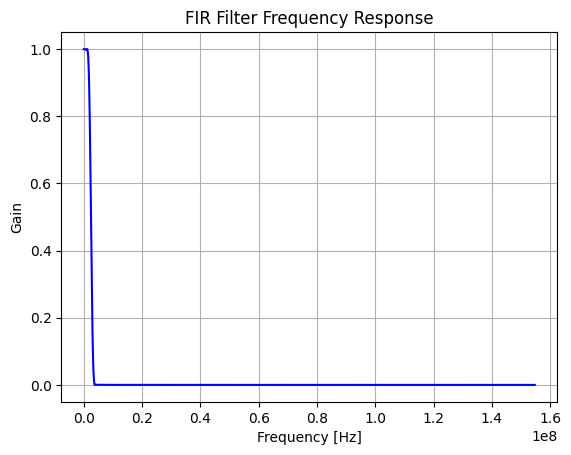

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import kaiserord, firwin, freqz, lfilter
import librosa

# Sampling frequency
fs = 44100.0

# Desired frequency response specifications
nyquist = 0.5 * fs  # Nyquist frequency
cutoff_freq = 350.0  # Cutoff frequency of the filter
passband_ripple = 0.1  # Passband ripple in dB
stopband_attenuation = 60.0  # Stopband attenuation in dB

# Calculate the Kaiser window parameters using kaiserord
num_taps, beta = kaiserord(stopband_attenuation, (cutoff_freq / nyquist))

# Design the FIR filter using the Kaiser window
taps = firwin(num_taps, cutoff_freq, window=('kaiser', beta), fs=fs)

# Plot the frequency response of the filter
w, h = freqz(taps, worN=4000, fs=fs)
plt.plot(0.5 * fs * w / np.pi, np.abs(h), 'b')
plt.title('FIR Filter Frequency Response')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Gain')
plt.grid()
plt.show()


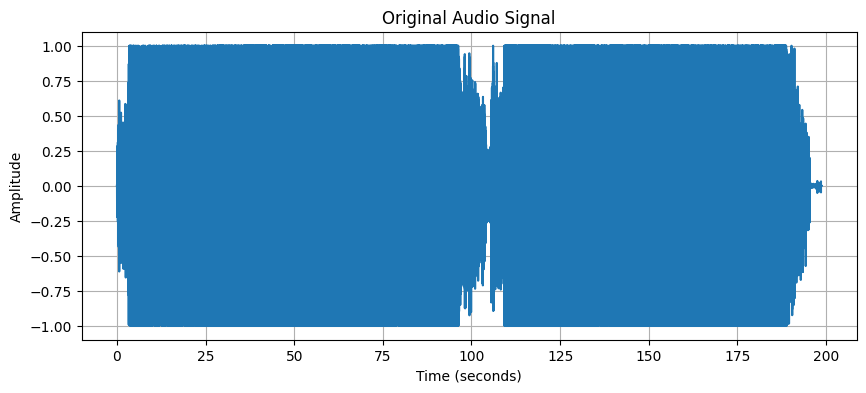

In [ ]:
file_path1 = '/content/Eptic - Propane [Monstercat Release].wav'  # Replace with the actual path to your audio file
audio_signal1, sampling_rate1 = librosa.load(file_path1, sr=None)
time1 = np.arange(0, len(audio_signal1)) / sampling_rate1

# Plot the original audio signal
plt.figure(figsize=(10, 4))
plt.plot(time1, audio_signal1)
plt.title('Original Audio Signal')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

In [ ]:
# Apply the FIR filter to the input signal
output_signal1 = lfilter(taps, 1.0, audio_signal1)

In [ ]:
from scipy.io.wavfile import write

audio_data_normalized1 = np.int16(output_signal1 * 32767)
# Save the array as a WAV file
output_file1 = 'output3.wav'
write(output_file1, sampling_rate1, audio_data_normalized1)



---



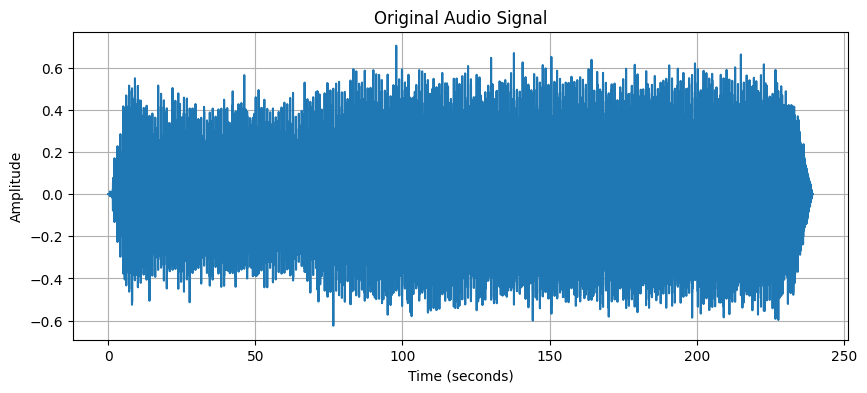

In [ ]:
file_path2 = '/content/Rick James - Love Gun (Live).wav'  # Replace with the actual path to your audio file
audio_signal2, sampling_rate2 = librosa.load(file_path2, sr=None)
time2 = np.arange(0, len(audio_signal2)) / sampling_rate2

# Plot the original audio signal
plt.figure(figsize=(10, 4))
plt.plot(time2, audio_signal2)
plt.title('Original Audio Signal')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

In [ ]:
# Apply the FIR filter to the input signal
output_signal2 = lfilter(taps, 1.0, audio_signal2)

In [ ]:
audio_data_normalized2 = np.int16(output_signal2 * 32767)
# Save the array as a WAV file
output_file2 = 'output4.wav'
write(output_file2, sampling_rate2, audio_data_normalized2)

#### 3. Equirriple Design

First, we need to undestand the frequencies we will be dealing with when working with music. Typically when recording songs, the sampling rate is 44.1kHz, this wil set a hard boundary for the highest frequency we will ever distinguishably hear.

Note*** we calculate the nyquist frequency because all frequency content generated over this frequency will be aliased and unusable.

Next, we need to understand the range of music we hope to use as features for any kind of music data processing.

https://www.masteringthemix.com/blogs/learn/understanding-the-different-frequency-ranges

According to this website, we can see that bass will typically occur in the 20-250 Hz range, and is mostly distinguishable from all other sounds. We will use bass as one of the features for our system, therefore a low-pass filter will be highly desireable.


#### Remez Low-Pass Filter

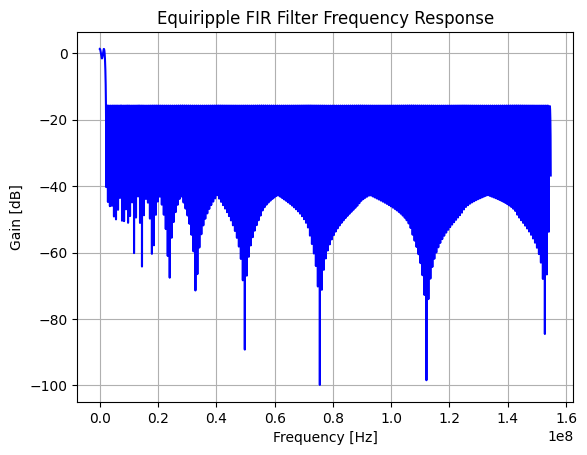

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import remez, freqz

# Parameters for the equiripple filter design
fs = 44100.0
cutoff_freq = 250.0
stopband_attenuation = 60.0
transition_width = 50.0  # Width of the transition band in Hz

# Calculate the number of taps for the equiripple filter design
nyquist = 0.5 * fs
#num_taps = remezord([0, cutoff_freq, cutoff_freq + transition_width, nyquist],
#                   [1, 0], [10**(-stopband_attenuation / 20), 10**(-stopband_attenuation / 20)])

# Design the equiripple FIR filter
#we are using the kaiser # of taps
taps = remez(num_taps, [0, cutoff_freq, (cutoff_freq + transition_width), nyquist], [1, 0], fs=fs)

# Plot the frequency response of the equiripple filter
w, h = freqz(taps, worN=8000, fs=fs)
plt.plot(0.5 * fs * w / np.pi, 20 * np.log10(np.abs(h)), 'b')
plt.title('Equiripple FIR Filter Frequency Response')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Gain [dB]')
plt.grid()
plt.show()


In [20]:
# Apply the FIR filter to the input signal
output_signal3 = lfilter(taps, 1.0, audio_signal1)
# Apply the FIR filter to the input signal
output_signal4 = lfilter(taps, 1.0, audio_signal2)

In [21]:
audio_data_normalized3 = np.int16(output_signal3 * 32767)
# Save the array as a WAV file
output_file3 = 'output5.wav'
write(output_file3, sampling_rate1, audio_data_normalized3)

audio_data_normalized4 = np.int16(output_signal4 * 32767)
# Save the array as a WAV file
output_file4 = 'output6.wav'
write(output_file4, sampling_rate2, audio_data_normalized4)

#### Remez Band-Pass Filter

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import remez, freqz

# Parameters for the bandpass filter design
fs = 44100.0
passband = [40.0, 250.0]  # Passband frequency range
stopband_attenuation = 60.0
transition_width = 30.0  # Width of the transition band in Hz

# Calculate the order of the remez filter using remezord
nyquist = 0.5 * fs
delta_f = transition_width / nyquist
#num_taps = remezord([0, passband[0] - transition_width, passband[0], passband[1], passband[1] + transition_width, nyquist],
#                    [0, 1, 0], [10**(-stopband_attenuation / 20), 10**(-stopband_attenuation / 20)])



In [32]:
[0, passband[0] - transition_width, passband[0], passband[1], passband[1] + transition_width, nyquist]

[0, 10.0, 40.0, 250.0, 280.0, 22050.0]

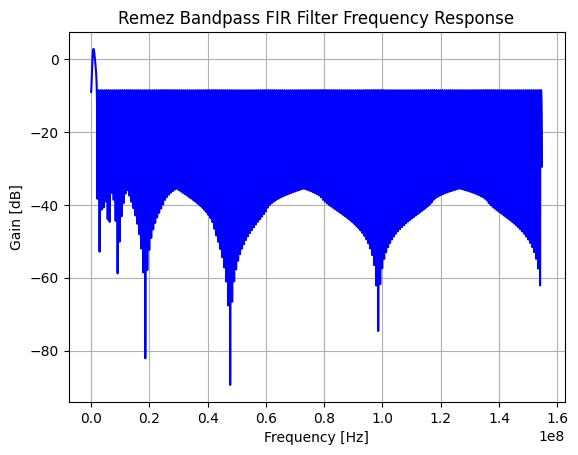

In [33]:
# Design the remez FIR filter
taps = remez(num_taps, [0, passband[0] - transition_width, passband[0], passband[1], passband[1] + transition_width, nyquist],
             [0, 1, 0], fs=fs)

# Plot the frequency response of the remez filter
w, h = freqz(taps, worN=8000, fs=fs)
plt.plot(0.5 * fs * w / np.pi, 20 * np.log10(np.abs(h)), 'b')
plt.title('Remez Bandpass FIR Filter Frequency Response')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Gain [dB]')
plt.grid()
plt.show()


In [34]:
# Apply the FIR filter to the input signal
output_signal5 = lfilter(taps, 1.0, audio_signal1)
# Apply the FIR filter to the input signal
output_signal6 = lfilter(taps, 1.0, audio_signal2)

audio_data_normalized5 = np.int16(output_signal5 * 32767)
# Save the array as a WAV file
output_file5 = 'output7.wav'
write(output_file5, sampling_rate1, audio_data_normalized5)

audio_data_normalized6 = np.int16(output_signal6 * 32767)
# Save the array as a WAV file
output_file6 = 'output8.wav'
write(output_file6, sampling_rate2, audio_data_normalized6)